In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [11]:
# Set a random seed
np.random.seed(0)
tf.random.set_seed(0)

In [12]:
# Load the stock price data (you can replace this with any stock you want)
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


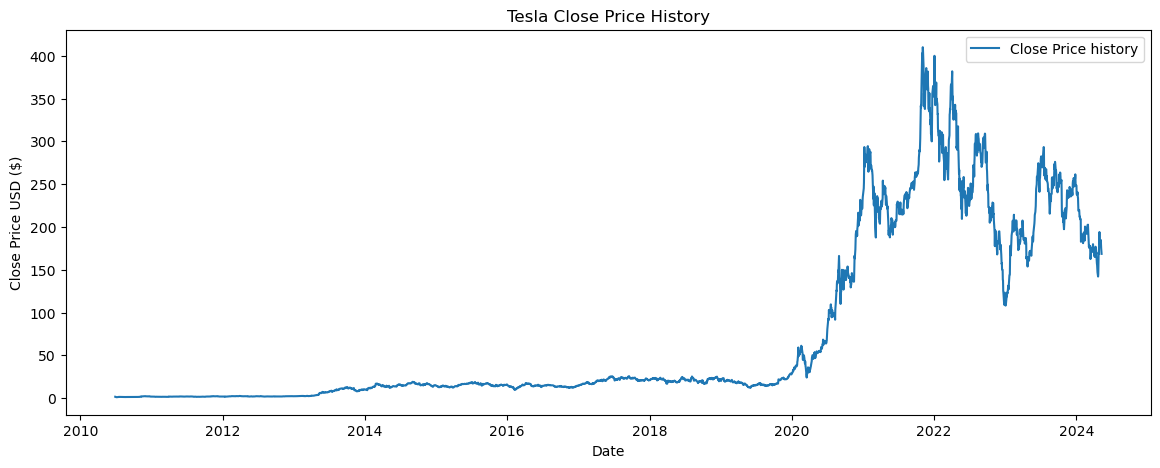

In [13]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set the 'Date' column as the index of the DataFrame
data.set_index('Date', inplace=True)

# Plot the closing price history
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label='Close Price history')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Close Price History')
plt.legend()
plt.show()

In [14]:
# Prepare data for LSTM model
# Filter closing price
closing_price = data['Close']

#change into a dataframe
closing_price = pd.DataFrame(closing_price)
closing_price = closing_price.rename(columns={0: 'Close'})

# Convert the data to numpy array
dataset = closing_price.values
dataset = dataset.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create training and testing data sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size, :]
test_data = scaled_data[train_size:len(scaled_data), :]

# Create the training dataset
x_train, y_train = [], []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert training dataset to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape data for LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create the testing dataset
x_test, y_test = [], dataset[train_size:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert testing dataset to numpy arrays
x_test = np.array(x_test)

# Reshape data for LSTM [samples, time steps, features]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
# Convert x_train to numpy array
x_train = np.array(x_train)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2732/2732 [==============================] - 53s 19ms/step - loss: 7.9202e-04


In [16]:
# Predict the stock prices
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

20/20 [==============================] - 1s 18ms/step


In [17]:
# Visualize the results
train = data[:train_size]
valid = data[train_size:]
# Adjust the validation set to match the length of the predictions
valid = valid[len(valid) - len(predictions):]

# Adjust y_test to match the length of the predictions
y_test = y_test[len(y_test) - len(predictions):]

# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print(f'Root Mean Squared Error: {rmse}')

#Calculate R2 Score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f'R2 Score: {r2}')




valid['Predictions'] = predictions

Root Mean Squared Error: 20.268907822036386
R2 Score: 0.8158877898098785


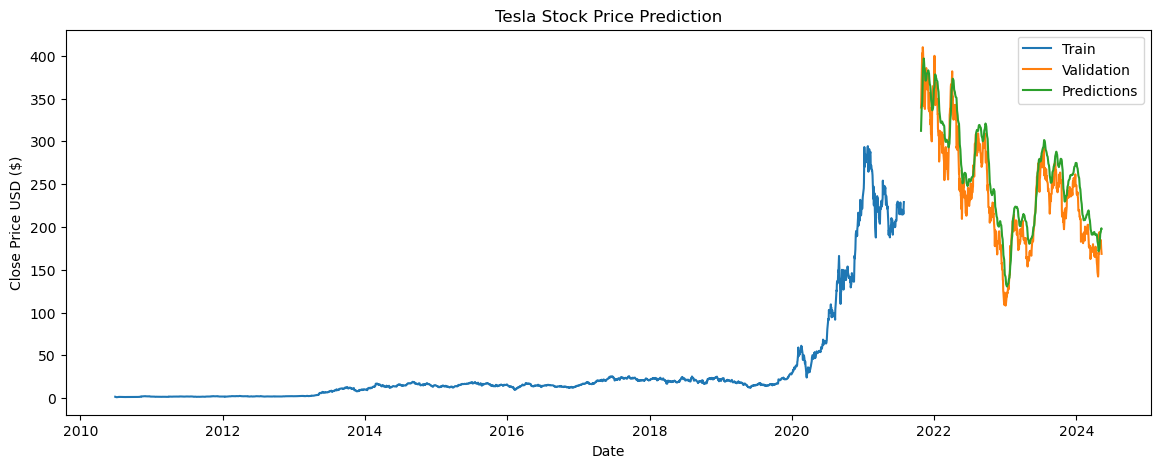

In [18]:
# Convert the index to datetime format
train.index = pd.to_datetime(train.index)
valid.index = pd.to_datetime(valid.index)

# Plot the data
plt.figure(figsize=(14, 5))
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Validation')
plt.plot(valid['Predictions'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Stock Price Prediction')
plt.legend()
plt.show()